<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 12. Shallow-water equations
## Dam break with `shallowWaterFoam`
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

**In this notebook, we will learn to**

- run the **shallow-water equations** on a typical dam break scenario
in `openFoam`, using `shallowWaterFoam`. 

**Prerequisites:** (text)

**Result:** You should get a figure similar to
<img src="images/DamBreak_Stoker.png" style=width:20cm>

<a href="#top">**Table of contents**</a>

1. [Solver and equations](#one)
2. [Implementation](#two)
3. [Running](#three)
4. [Post-processing](#four)
5. [Technical aspects](#five)

<div id="one"></div>

----
## 1. Solver and equations

`shallowWaterFoam` is a 

- transient
- inviscid
- rotational

solver for the shallow-water equations:
$$
\begin{array}{rcl}
\frac{\partial (h+h_0)}{\partial t}
+ \frac{\partial (hu)}{\partial x}
+ \frac{\partial (hv)}{\partial y} &=& 0 \\
\frac{\partial (hu)}{\partial t}
+ \frac{\partial (hu^2 + \frac{1}{2}gh^2)}{\partial x}
+ \frac{\partial (huv)}{\partial y} &=& - g h \nabla(h+h_0) \\
\frac{\partial (hv)}{\partial t}
+ \frac{\partial (huv)}{\partial x}
+ \frac{\partial (hv^2 + \frac{1}{2}gh^2)}{\partial y} &=& - g h \nabla(h+h_0)
\end{array}
$$
with
- $h$ [m] - water height,
- $h_0$ [m] - bottom topography,
- $u,v$ [m/s] - velocity in $x$- and $y$-direction,
- $g$ [m/s$^2$] - grav. acceleration,
- $t$ [s] - time,
- $x,y$ [m] - $x$- and $y$-coordinates.


Note that the variables are $h$ [m], $hu$ [m$^2$/s], and $hv$ [m$^2$/s]!

The equations are then solved by `shallowWaterFoam`.

<div id="two"></div>

----
## 2.  Implementation

We consider flow in a box 10x10 m long, 2 m nominal height (not used):
<img src="images/HagenPoiseuille.jpg" style=width:15cm>
Black numbers mark sizes, red numbers are vertex numbers.

For the calculation of velocities and pressure, we have an inflow face (0 4 7 3) with fixed velocity
in $y$ direction, and an outflow face (1 2 6 2) with fixed (kinematic) pressure.
The numbering of faces mark the **unit normal vector** in a right-hand side sense, thus for both
faces, the unit vector points outwards.

The other faces (left,right,top,bottom) will be defined as **no-slip** boundaries, 
thus they will be defined with velocity zero.

We have to set up the **mesh**, the **initial conditions**, a **temperature anomaly**, then **run** the program.
This is done for the 2D case in the following.

### Directory structure and files

~~~
DamBreak_shallowWaterFoam
|-- 0
  |-- h
  |-- h0
  |-- U
|- constant
  |-- gravitationalProperties
|- system
  |-- blockMesh
  |-- controlDict
  |-- fvSchemes
  |-- fvSolution
  |-- setFieldsDict
~~~

----

- `system/blockMeshDict`
    - We use no scaling (`convertToMeters`)
    - Eight vertices are defined (`vertices`), use the figure above. The model domain is 10m long in $y$ direction, 
    and has dimensions of $\pm$0.5m in $x$ and $z$ direction.
    - From the eight vertices, a single block (`blocks`) is created as mesh,
    discretised with 100 points in $y$ direcion, ans 10 points in $x$ and $z$ directions.
    Choose direction of points such that the normal vectors are pointing outside! Create one block, withh 1000 elements in $x$ direction.
    - All edges are straight, thus the keyword `edges` is empty.
    - The boundries are defined (`boundary`). Only two faces, inflow and outflow side, are relevant, 
    and defined as patches. The other four faces (left,right,top,bottom), are no-slip boundaries.

<details><summary><b>> Show code</b></summary>
    
~~~
scale   1;

vertices
(
    ( 0  0 0)
    (10  0 0)
    (10 10 0)
    ( 0 10 0)
    ( 0  0 2)
    (10  0 2)
    (10 10 2)
    ( 0 10 2)
);

blocks
(
    hex (0 1 2 3 4 5 6 7) (200 10 1) simpleGrading (1 1 1)
);

edges
(
);

boundary
(
    sides
    {
        type patch;
        faces
        (
            (3 7 6 2)
            (1 5 4 0)
        );
    }
    inlet
    {
        type patch;
        faces
        (
            (0 4 7 3)
        );
    }
    outlet
    {
        type patch;
        faces
        (
            (2 6 5 1)
        );
    }
    frontAndBack
    {
        type empty;
        faces
        (
            (0 3 2 1)
            (4 5 6 7)
        );
    }
);

mergePatchPairs
(
);
~~~
</details>

----

- `0/h`
    - $h$ [m] is the **water depth**
    - Dimensions are set for height (`dimensions`).
    - Set water heights to zero (reset later by setFields).
    - At the `inlet` and `outlet`, a Neumann boundary condition is set (zeroGradient).
    - At the `sides`, a Neumann boundary condition is set (zeroGradient).
    - Fix `frontAndBack` as empty faces (no calculation).

<details><summary><b>> Show code</b></summary>
    
~~~
dimensions      [0 1 0 0 0 0 0];
internalField   uniform 1.0;
boundaryField
{
    sides
    {
        type            zeroGradient;
    }

    inlet
    {
        type            zeroGradient;
    }

    outlet
    {
        type            fixedValue;
        value           $internalField;
    }

    frontAndBack
    {
        type            empty;
    }
}
~~~
</details>

----

- `0/h0`
    - $h0$ [m] is the **bottom topography**
    - Dimensions are set for height (`dimensions`).
    - Set topography to zero (reset later by setFields).
    - At the `inlet` and `outlet`, a Neumann boundary condition is set (zeroGradient).
    - At the `sides`, a Neumann boundary condition is set (zeroGradient).
    - Fix `frontAndBack` as empty faces (no calculation).

<details><summary><b>> Show code</b></summary>

~~~
dimensions      [0 1 0 0 0 0 0];
internalField   uniform 0.0;
boundaryField
{
    sides
    {
        type            zeroGradient;
    }

    inlet
    {
        type            zeroGradient;
    }

    outlet
    {
        type            fixedValue;
        value           $internalField;
    }

    frontAndBack
    {
        type            empty;
    }
}
~~~
</details>

----

- `0/hU`
    - $hU$ is a flux vector normalized to length [m$^2$/s].
    - Dimensions are set for velocity time height (`dimensions`).
    - Set all pressures to zero gradient, 
    - except the outlet face, where a fixed value is used
    and set to 0 m/s.
    - Note that for `icoFoam`, which is an incompressible solver, the pressure is scaled by density:
    $$
    p^* = \frac{p}{\rho}
    $$
    with $p$ [Pa] pressure and $\rho$ [kg/m$^3$] density, thus $p^*$ [m$^2$/s$^2$].

<details><summary><b>> Show code</b></summary>
    
~~~
dimensions      [0 2 -1 0 0 0 0];
internalField   uniform (0.00 0 0);
boundaryField
{
    sides
    {
        type            slip;
    }

    inlet
    {
        type            fixedValue;
        value           $internalField;
    }

    outlet
    {
        type            zeroGradient;
    }

    frontAndBack
    {
        type            empty;
    }
}
~~~
</details>

----

- `constant/gravitationalProperties`
    - define **gravitational acceleration** $g$ [m/s$^2$] from
    - **Rotation velocity vector** $\Omega$ [1/s] and
    - **Flag for rotation** $rotating$ [true,false]

<details><summary><b>> Show code</b></summary>

~~~
g            g           [0 1 -2 0 0 0 0]  (0 0 -9.81);
rotating     false;
Omega        Omega       [0 0 -1 0 0 0 0]  (0 0 7.292e-5);
~~~
</details>

----

- `system/controlDict`

    - Our example starts from (`startFrom`), set to time 0 (`startTime`).
    - We run the example for 2 seconds (`stopAt`), set with (`endTime`).
    - Time step is set to 0.004 seconds (`deltaT`).
    - We write the solution every 0.2 second (`writeInterval`) of
    simulation time (`writeControl runTime`).
    - We keep all solution directories (`purgeWrite 0`).
    - We save the solution in ascii format (`writeFormat ascii`).
    - Write precision is set to 8 digits (`writePrecision 6`). 
    - The option `runTimeModifiable` is on, we therefore can modify all
    these entries while we are running the simulation.

<details><summary><b>> Show code</b></summary>

~~~
application     shallowWaterFoam;
startFrom       startTime;
startTime       0;
stopAt          endTime;
endTime         2;
deltaT          0.0040;
writeControl    runTime;
writeInterval   0.2;
purgeWrite      0;
writeFormat     ascii;
writePrecision  6;
writeCompression off;
timeFormat      general;
timePrecision   6;
runTimeModifiable false;
~~~
</details>

----

- `system/fvSchemes`

    - Time is discretised with the Euler method (`ddtSchemes`).
    - Gradients are solved with the Gauss linear methods (`gradSchemes`).
    - Divergence is solved with a linear interpolation method (`divSchemes`).
    - Laplacians are solved with a Gauss linear method (`laplacianSchemes`).

<details><summary><b>> Show code</b></summary>

~~~
ddtSchemes
{
    default         CrankNicolson 0.9;
}

gradSchemes
{
    default         Gauss linear;
}

divSchemes
{
    default         none;
    div(phiv,hU)    Gauss LUST un;
}

laplacianSchemes
{
    default         Gauss linear uncorrected;
}

interpolationSchemes
{
    default         linear;
}

snGradSchemes
{
    default         uncorrected;
}
~~~
</details>

----

- `system/fvSolution`

    - Pressure $p$ is solved with the **GAMG** method to a given absolute tolerance,
    and a given relative tolerance.
    - For the final pressure calculation in the **PISO** loop, a more accurate
    tolerance is required.
    - Velocities $U$ are solved with the **PBiCG** method and **DILU** preconditioning,
    and toleances are set.
    - The **PISO** loop is run only once.

<details><summary><b>> Show code</b></summary>

~~~
solvers
{
    h
    {
        solver          PCG;
        preconditioner  DIC;
        tolerance       1e-10;
        relTol          0.01;
    }

    hFinal
    {
        $h;
        tolerance       1e-10;
        relTol          0;
    }

    hU
    {
        solver          smoothSolver;
        smoother        GaussSeidel;
        tolerance       1e-10;
        relTol          0.1;
    }

    hUFinal
    {
        $hU;
        tolerance       1e-10;
        relTol          0;
    }
}

PIMPLE
{
    nOuterCorrectors 3;
    nCorrectors      1;
    nNonOrthogonalCorrectors 0;

    momentumPredictor yes;
}
~~~
</details>







### Courant number

The **Courant-Friedrich-Levy number** $CFL$ is defined as
$$
CFL = u \frac{\Delta t}{\Delta x}
$$
with 
- $u$ [m/s] max. velocity, 
- $\Delta t$ [s] time step,
- $\Delta x$ [m] spatial step.

For stable solutions, the conditions $CFL < 1$ needs to be fulfilled.

<div id="three"></div>

----
## 3. Running

Running a particular example is done with the following set of commands:

~~~
$ foamCleanTutorials
$ blockMesh
$ setFields
$ shallowWaterFoam
~~~

If the run was successful, create a dummy file `show.foam` in the directory and
open the run in `paraview`.

<img src="images/DamBreak_Stoker.png" style=width:20cm>

<div id="four"></div>

----
## 4. Post-processing: Profiles

Use dictionary `system/sampleDict` to extract data after main run.
- We define `sets`
- We set the output format to ascii (`setFormat raw`).
- We set the interpolation as cell-point centeres (*interpolationScheme`).
- The fields are defined (`fields`). Note that is matters, wether the different fields
are in one line or in separate line, as this controls the naming of the output files ...
- Then the sets are given, with a name (e.g. `DamBreak_along`), the sample type
(`type uniform`) and the sample number (`nPoints 100`), the axes to sample (`xyz`means
all three axes), and the start and end points of the uniform sampling (`start`, `end`).

<details><summary><b>> Show code</b></summary>
    
~~~
type sets;

setFormat raw;

//interpolationScheme cell;
interpolationScheme cellPoint;
//interpolationScheme cellPointFace;

// Fields to sample.
fields
(
    h 
    U
);

sets
(

    DamBreak_along
    {
        type            uniform;
    nPoints     100;

        axis            xyz;
        start           ( 0   0 0);
        end             (10   0 0);
    }

);
~~~
</details>

Run:

~~~
$ postProcess -func sampleDict
~~~

The `postProcess` code creates in this case sampled data for water depth $h$ and velocity $U$:
- along the channel:  
    - `postProcessing/sampleDict/xx/DamBreak_along_h.xy`
    - `postProcessing/sampleDict/xx/DamBreak_along_U.xy`
    
with $xx$ the saved time direcory.

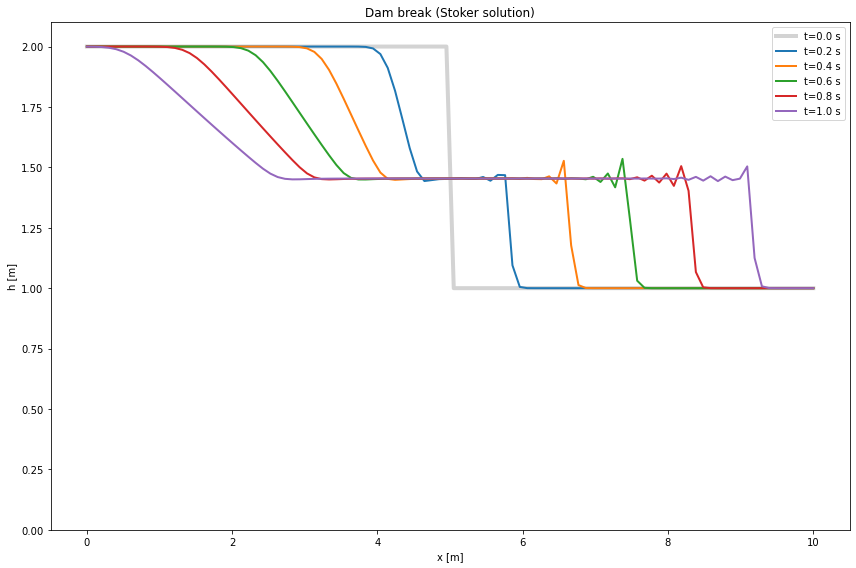

In [16]:
import numpy as np
import matplotlib.pyplot as plt
    
# load shallowWaterFoam postprocessed data
data0_0 = np.loadtxt('data/DamBreak/0/DamBreak_along_h.xy')
data0_2 = np.loadtxt('data/DamBreak/0.2/DamBreak_along_h.xy')
data0_4 = np.loadtxt('data/DamBreak/0.4/DamBreak_along_h.xy')
data0_6 = np.loadtxt('data/DamBreak/0.6/DamBreak_along_h.xy')
data0_8 = np.loadtxt('data/DamBreak/0.8/DamBreak_along_h.xy')
data1_0 = np.loadtxt('data/DamBreak/1/DamBreak_along_h.xy')

plt.figure(figsize=(12,8))
plt.ylim(0,2.1)
plt.xlabel('x [m]')
plt.ylabel('h [m]')
plt.title('Dam break (Stoker solution)')
plt.plot(data0_0[:,0],data0_0[:,3],linewidth=4,color='lightgray',label='t=0.0 s')
plt.plot(data0_2[:,0],data0_2[:,3],linewidth=2,label='t=0.2 s')
plt.plot(data0_4[:,0],data0_4[:,3],linewidth=2,label='t=0.4 s')
plt.plot(data0_6[:,0],data0_6[:,3],linewidth=2,label='t=0.6 s')
plt.plot(data0_8[:,0],data0_8[:,3],linewidth=2,label='t=0.8 s')
plt.plot(data1_0[:,0],data1_0[:,3],linewidth=2,label='t=1.0 s')
plt.legend()

plt.tight_layout()

----
As we have choosen a Reynolds number in the **laminar** flow regime, we do not really need a **transient**
solver like `icoFoam`. We can instead run the simulation with a **steady-state** solver, e.g. 
`simpleFoam` ...

[next>](Dynamics_lab06_HagenPoiseuille_simpleFoam)

... done